In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [7]:
final_df = pd.read_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Data/02 Feature Engineered Data/final_data_after_feat_engg_20210909.csv',index_col=0).reset_index(drop=True)
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,2013-04-01,93.0,106.0,92.2,104.0,52572,139256,48809,6695826,6.550211e+13,...,0.134009,0.001051,-0.024929,-0.023878,-113.273476,30476.415612,30363.142136,14998.899375,55689.291569,70688.190944
1,2013-04-02,104.0,118.4,99.0,118.0,63095,175443,62276,6695826,6.184560e+13,...,0.149929,0.011957,-0.021940,-0.009982,126.563476,30508.056481,30634.619957,16891.203618,59912.092474,76803.296091
2,2013-04-03,118.0,147.0,110.0,135.0,63766,184209,69174,6695826,6.027037e+13,...,0.157742,0.034832,-0.013232,0.021600,-106.799542,30481.356595,30374.557054,17100.252403,64187.155575,81287.407978
3,2013-04-04,135.0,142.1,116.4,132.1,66738,221568,71753,6695826,5.527246e+13,...,0.162305,0.069927,0.004250,0.074177,58.570562,30495.999236,30554.569798,14903.051588,67912.918472,82815.970060
4,2013-04-05,132.1,144.9,130.2,142.3,61215,190067,69310,7005058,5.181545e+13,...,0.151506,0.055290,0.018073,0.073363,149.158958,30533.288975,30682.447934,17313.693182,72241.341767,89555.034949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,2021-09-14,44950.2,47247.6,44718.7,47077.5,267959,599399,491643,18415156832118,1.555172e+20,...,0.084843,-0.015534,-0.028798,-0.044332,-24.955463,6695.976410,6671.020946,-261009.855525,264339.907540,3330.052015
3089,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.330283e+20,...,0.070818,0.019459,-0.023933,-0.004473,-31.348006,6688.139408,6656.791402,-373316.837279,171010.698220,-202306.139059
3090,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297e+20,...,0.058943,0.043845,-0.012971,0.030874,-38.047728,6678.627476,6640.579748,-526466.959548,39393.958333,-487073.001215
3091,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835e+20,...,0.048329,0.035699,-0.004047,0.031652,-42.906613,6667.900823,6624.994210,-368482.672535,-52726.709800,-421209.382335


In [12]:
final_df.fillna(value=0, inplace=True)
final_df.isnull().values.any()

False

In [13]:
def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]

    fig,ax = plt.subplots(figsize=(14,12))
    ax = sns.barplot(x = "Feature Importance",y = "Feature Name",
                    data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')

    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    #https://stackoverflow.com/a/43807666
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    # plt.colorbar(sm,ticks=np.linspace(minfi,maxfi,n_select_features),
    #             boundaries=np.arange(minfi,maxfi+0.001,.0001))
    ax.xaxis.grid()
    plt.show()
    return feat_imp_df,df[feat_imp_df['Feature Name']]

In [14]:
X = final_df.drop(['Date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])
X_scaled

,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,mining_profitability,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,0.000388,0.000479,0.000680,0.000561,0.048669,0.068533,0.025709,0.000000e+00,6.926116e-08,0.540741,...,0.791206,0.427493,0.451094,0.418200,0.633362,0.848929,0.836064,0.681407,0.496733,0.497508
1,0.000561,0.000671,0.000790,0.000781,0.071531,0.107780,0.044965,0.000000e+00,5.075741e-08,0.598410,...,0.803548,0.429960,0.451452,0.419506,0.716317,0.849984,0.844986,0.681728,0.497029,0.497882
2,0.000781,0.001113,0.000967,0.001049,0.072989,0.117287,0.054828,0.000000e+00,4.278598e-08,0.662970,...,0.809604,0.435134,0.452493,0.422472,0.635601,0.849094,0.836439,0.681764,0.497328,0.498155
3,0.001049,0.001037,0.001071,0.001004,0.079446,0.157806,0.058516,0.000000e+00,1.749411e-08,0.657353,...,0.813142,0.443073,0.454583,0.427410,0.692800,0.849582,0.842355,0.681390,0.497589,0.498249
4,0.001004,0.001080,0.001293,0.001164,0.067447,0.123641,0.055022,1.234633e-08,0.000000e+00,0.745205,...,0.804770,0.439762,0.456235,0.427334,0.724133,0.850825,0.846558,0.681800,0.497892,0.498660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,0.707069,0.729064,0.720260,0.740622,0.516608,0.567590,0.658899,7.352390e-01,7.869926e-01,0.000019,...,0.753091,0.423742,0.450632,0.416279,0.663910,0.056180,0.057367,0.634463,0.511338,0.493397
3089,0.740477,0.747438,0.752915,0.757213,0.518468,0.716530,0.671207,7.352390e-01,6.731878e-01,0.000019,...,0.742218,0.431657,0.451213,0.420023,0.661698,0.055918,0.056900,0.615362,0.504806,0.480847
3090,0.757200,0.748120,0.757694,0.751185,0.523404,0.804252,0.681132,7.352390e-01,6.590256e-01,0.000019,...,0.733012,0.437173,0.452524,0.423343,0.659381,0.055601,0.056367,0.589315,0.495593,0.463466
3091,0.751149,0.743102,0.753639,0.743856,0.522982,0.698451,0.669738,7.352390e-01,6.441164e-01,0.000021,...,0.724784,0.435331,0.453591,0.423416,0.657701,0.055244,0.055855,0.616184,0.489144,0.467486


In [15]:
y = final_df['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=1)
rf.fit(X_scaled,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.0s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


RandomForestRegressor(n_jobs=-1, random_state=1, verbose=5)

In [16]:
feat_range = list(range(10,60,5))

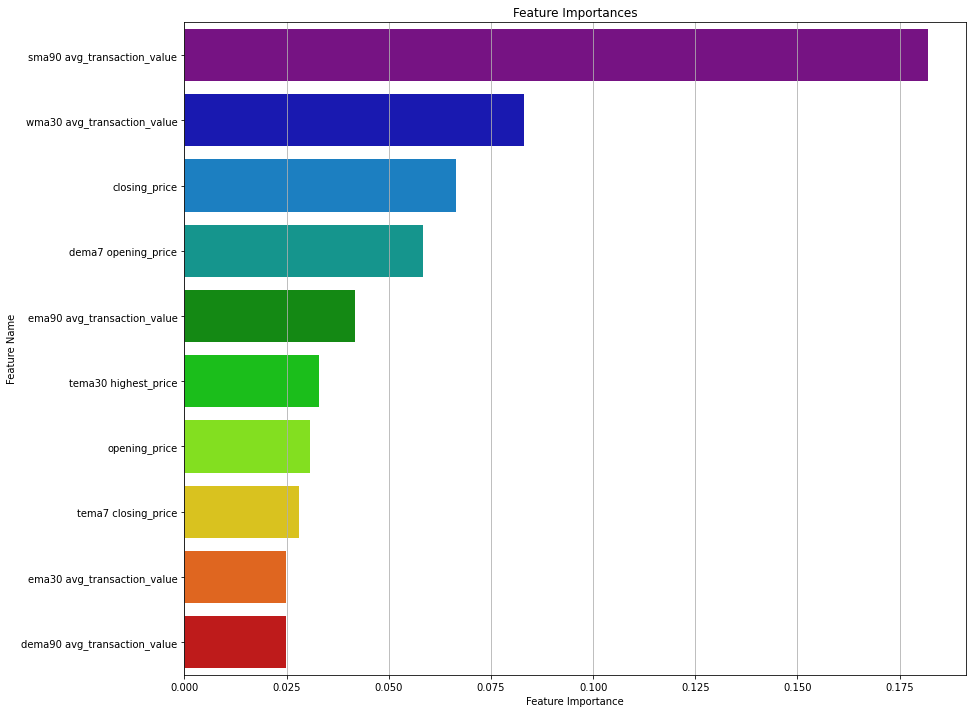

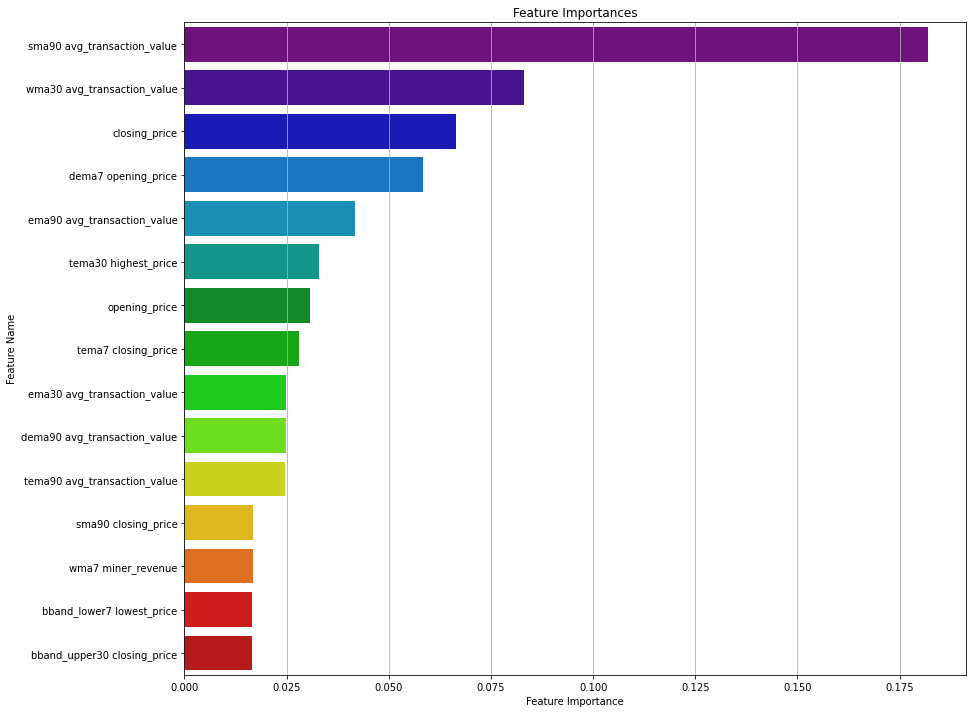

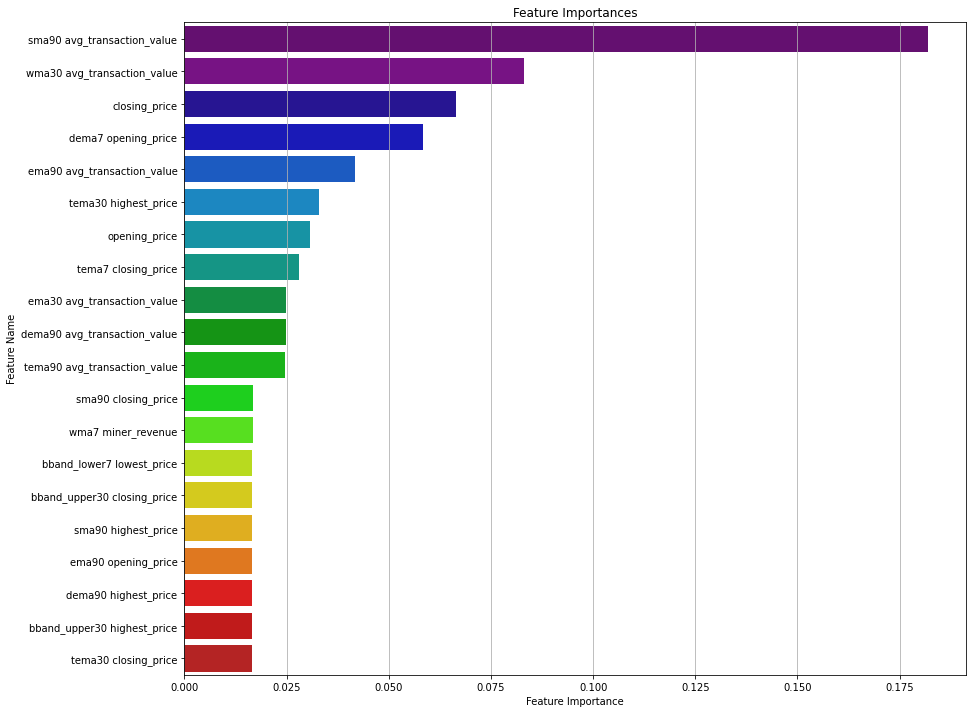

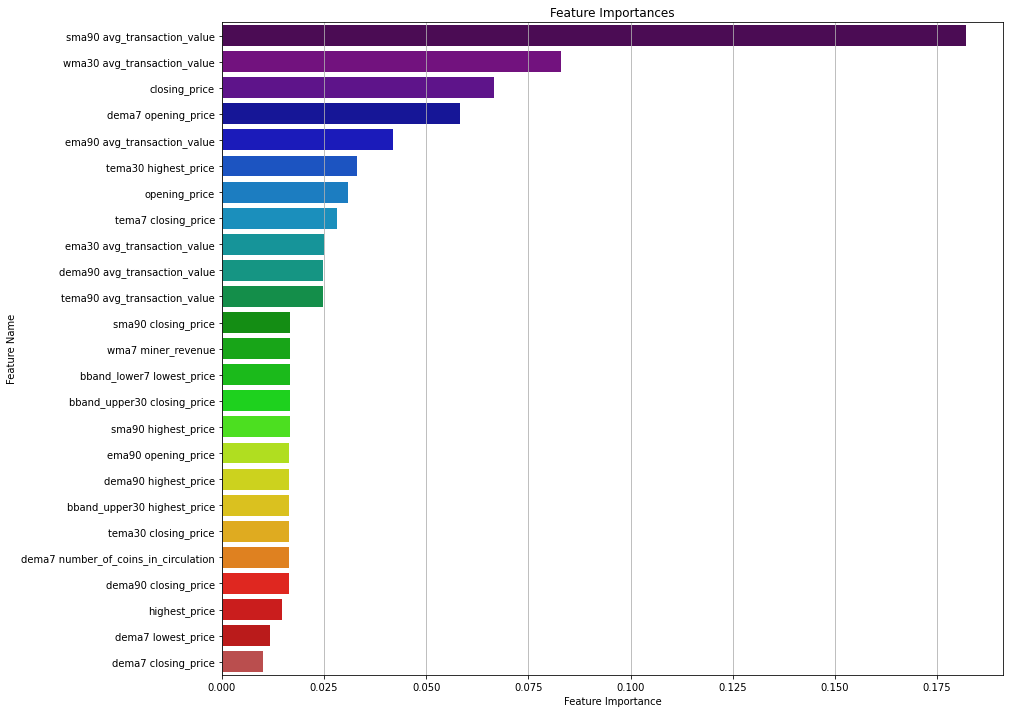

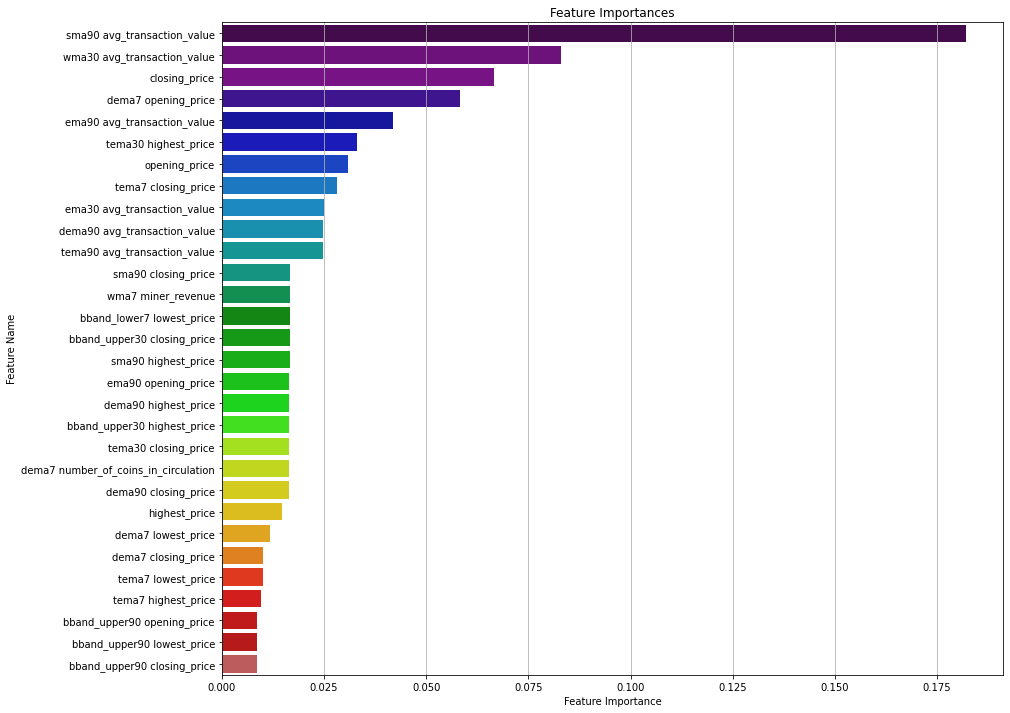

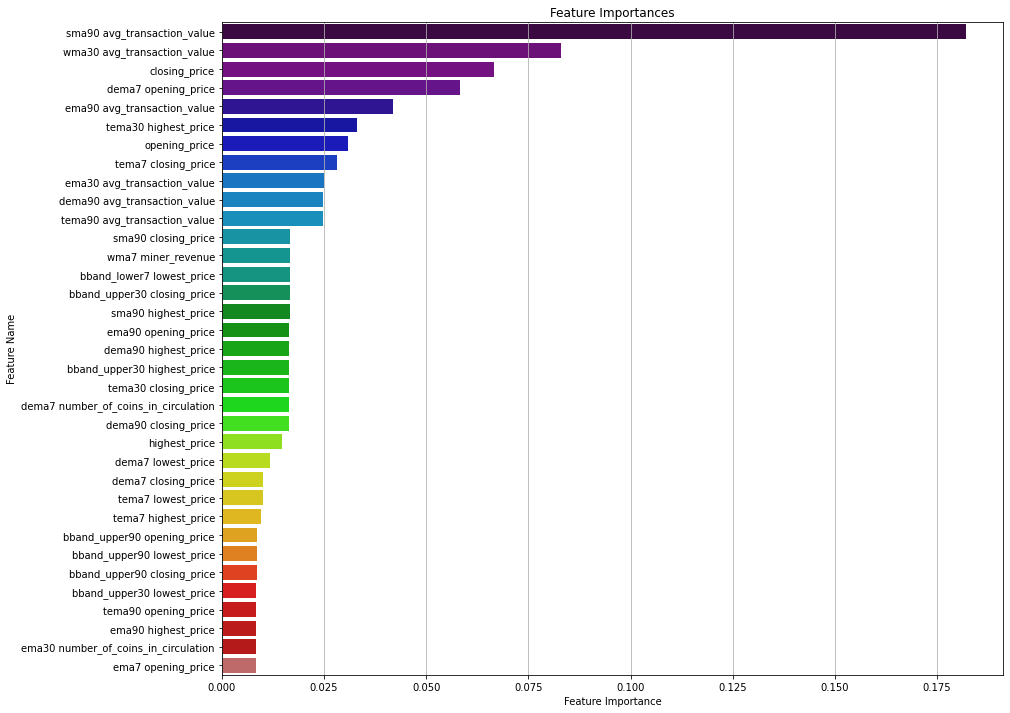

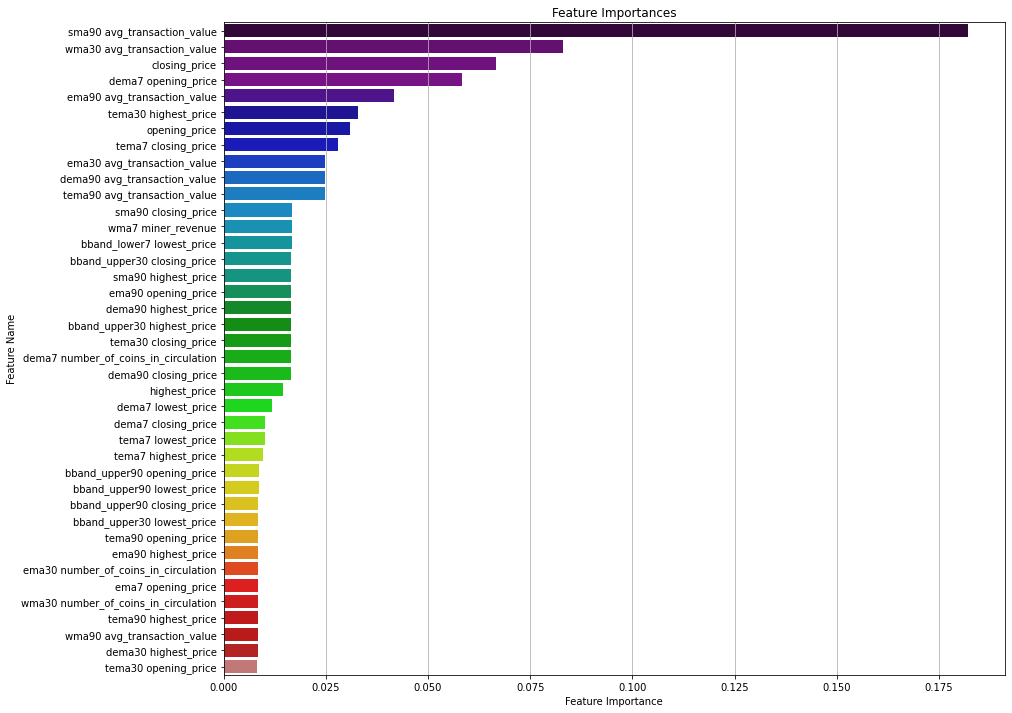

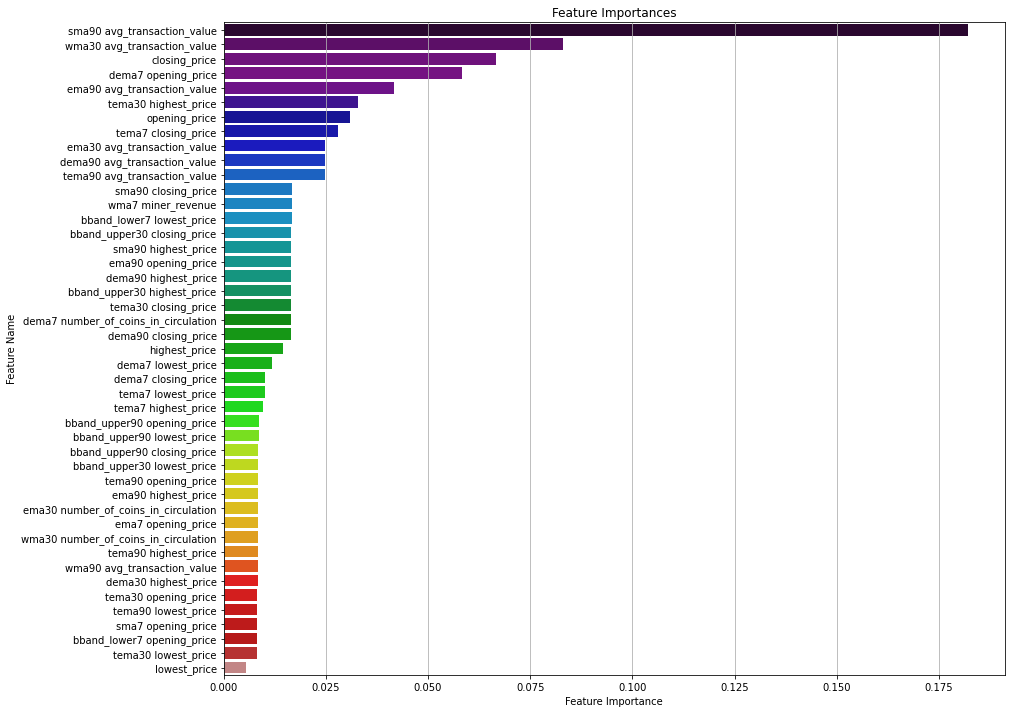

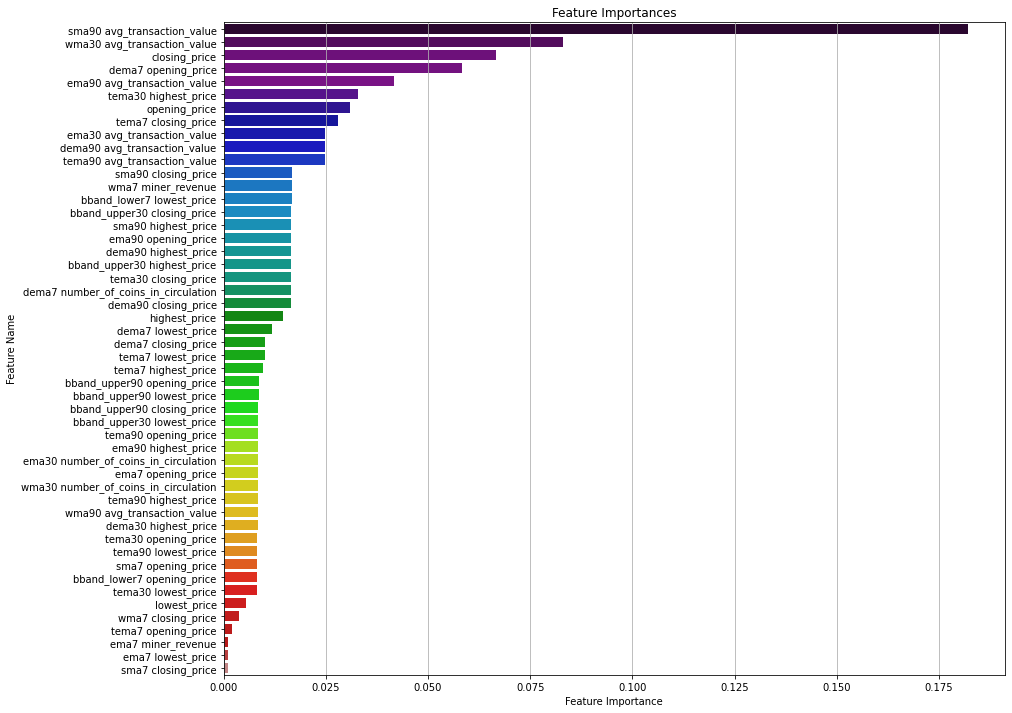

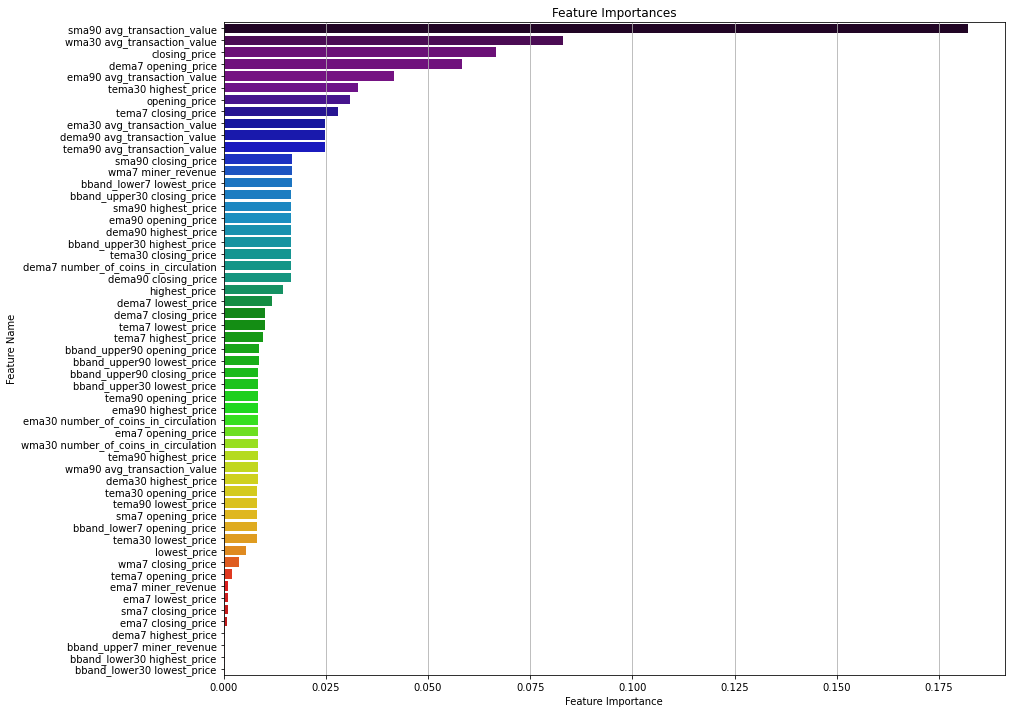

In [18]:
for i in feat_range:
    feat_imp_df,final_df_next_day = feature_imp(X_scaled,rf.feature_importances_,i)
    final_df_next_day.insert(loc=0, column='Date', value=final_df['Date'])
    final_df_next_day['next_day_closing_price'] = final_df['next_day_closing_price']
    feat_imp_df.to_csv(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Data/03 Feature Selected Data/feature_imp_20210919_{i}.csv',index=False)
    final_df_next_day.to_csv(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Data/03 Feature Selected Data/final_df_next_day_20210919_{i}.csv',index=False)